In [25]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import cv2
import os
import re

from src.background_removal import get_mask_and_foreground, get_mask_and_foreground_w2, evaluate_pixel_mask, evaluate_masks
from src.image_dataset import ColorSpace, ImageDataset, DescriptorType

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week3')
os.chdir(BASE_PATH)
print(BASE_PATH)


DATA_DIRECTORY = '../data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/projects/master/c1/Team5/week3


In [26]:
def validate_order(list_1: list[str], list_2: list[str]) -> bool:
    assert len(list_1) == len(list_2)

    for i in range(0, len(list_1)):
        if list_1[i].split('.')[0] != list_2[i].split('.')[0]:
            print(i, list_1[i], list_2[i])
            return False
    return True


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 36.32it/s]


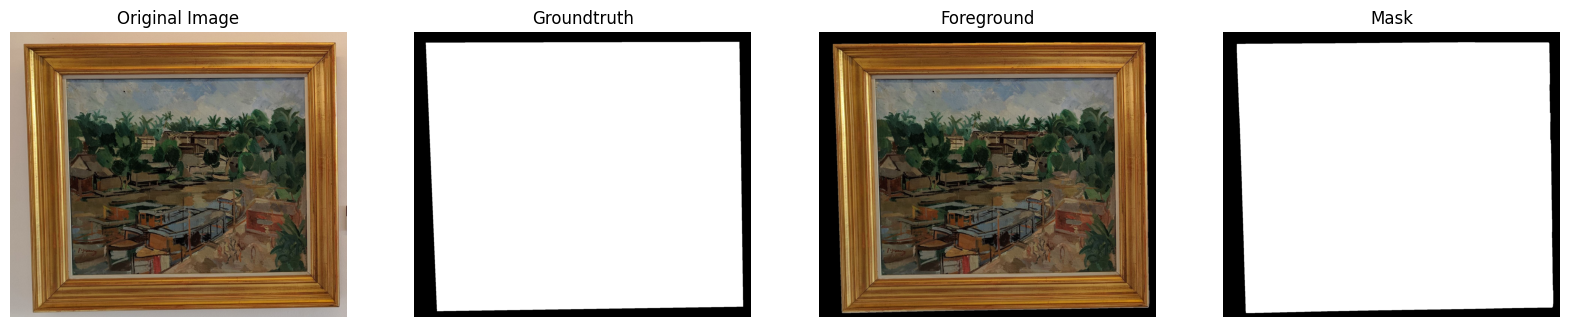

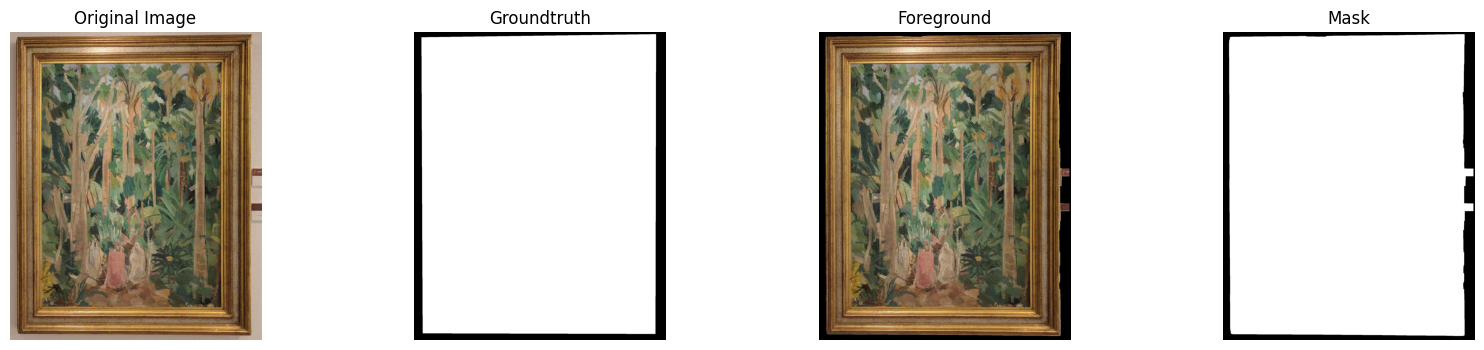

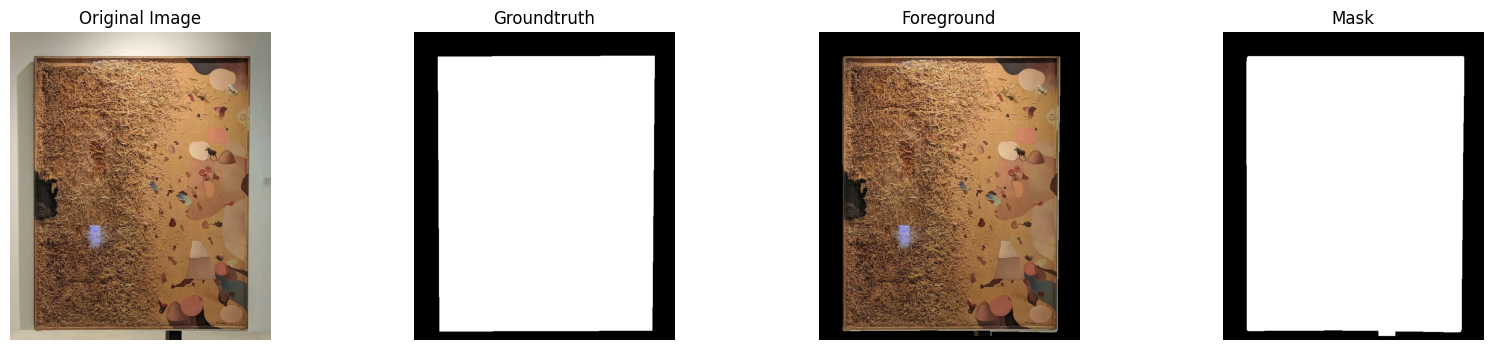

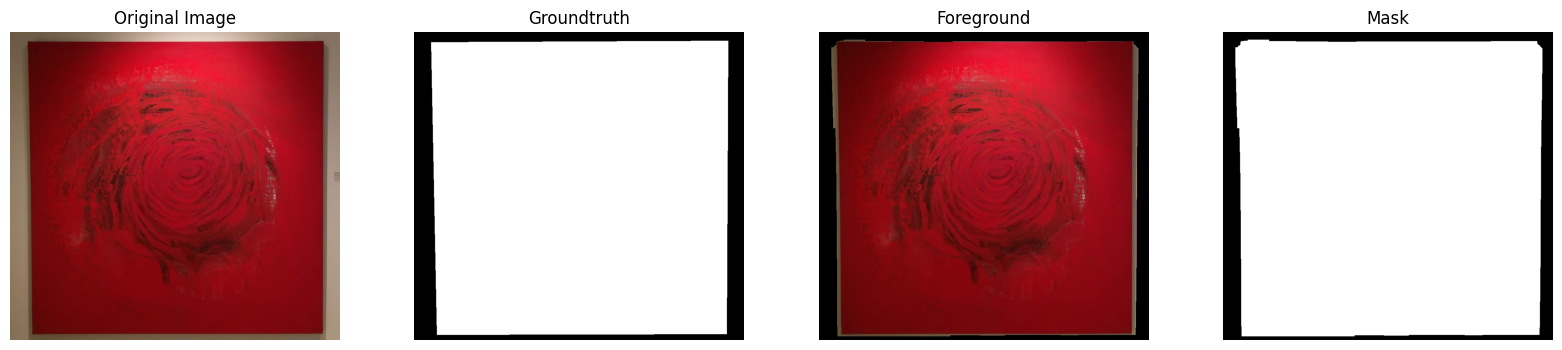

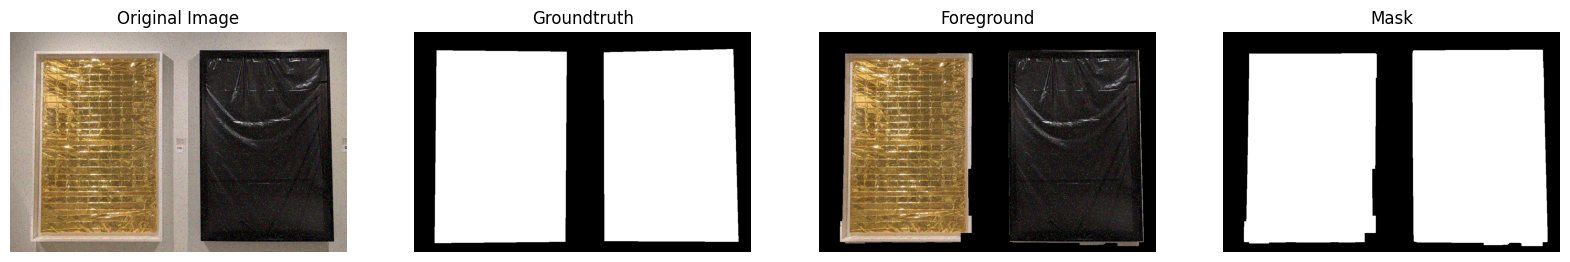

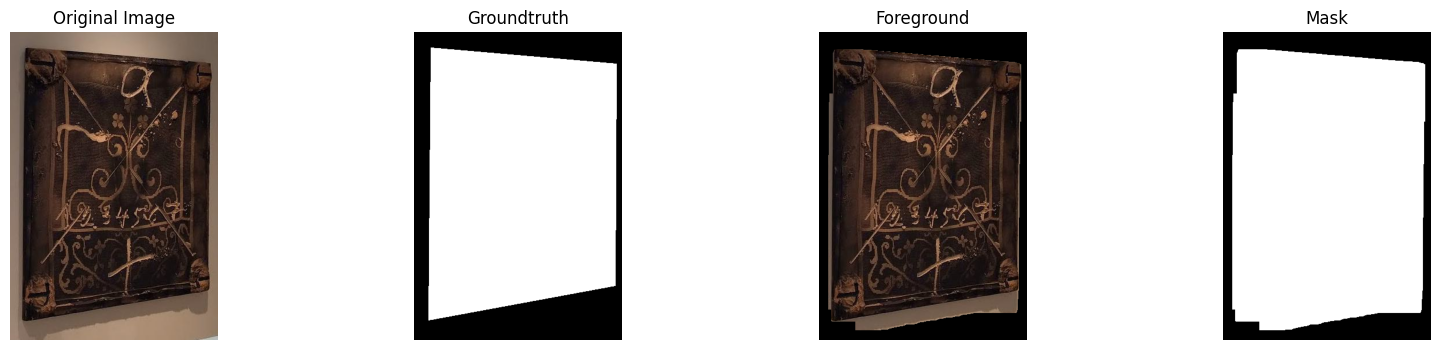

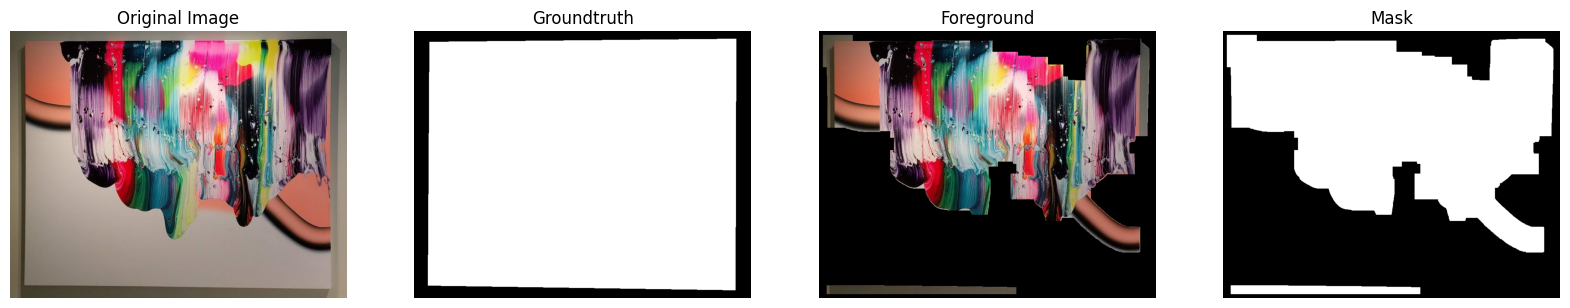

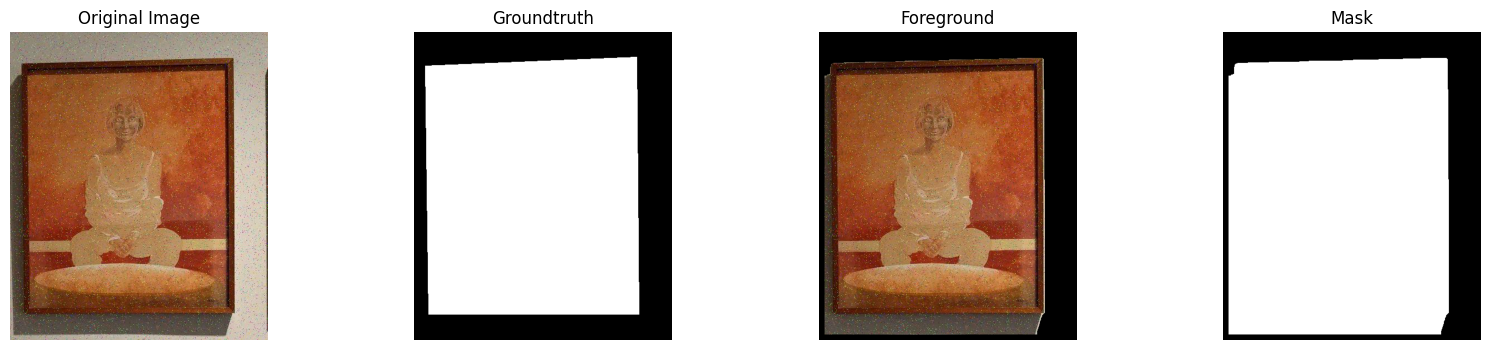

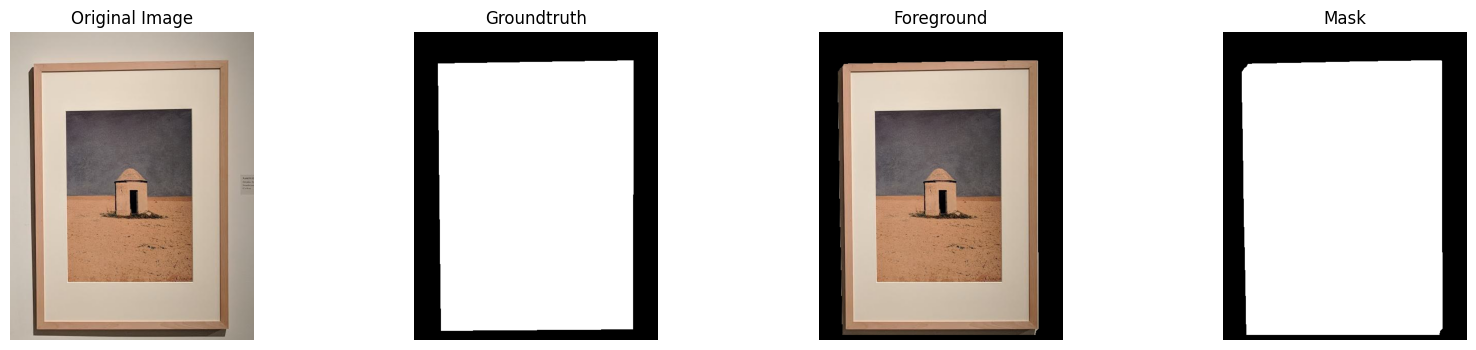

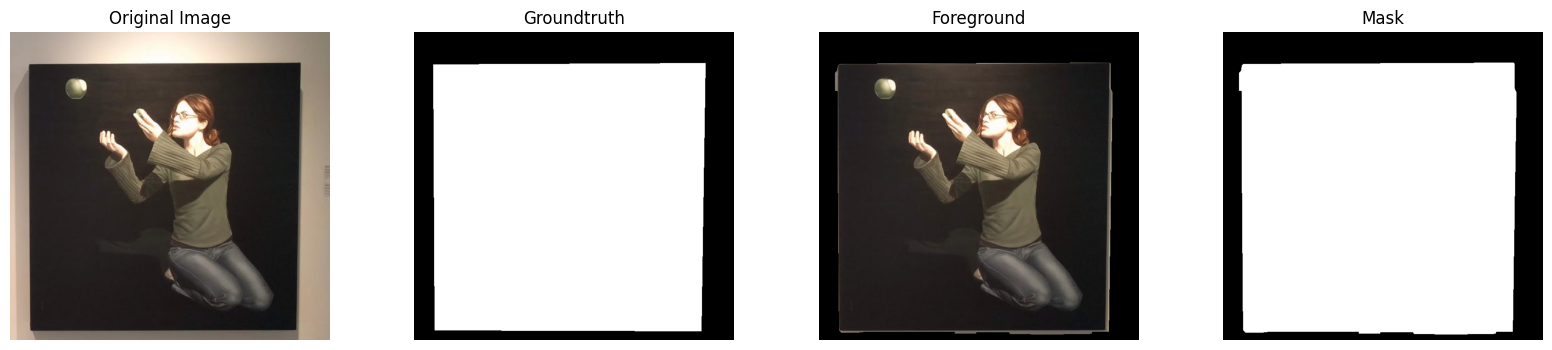

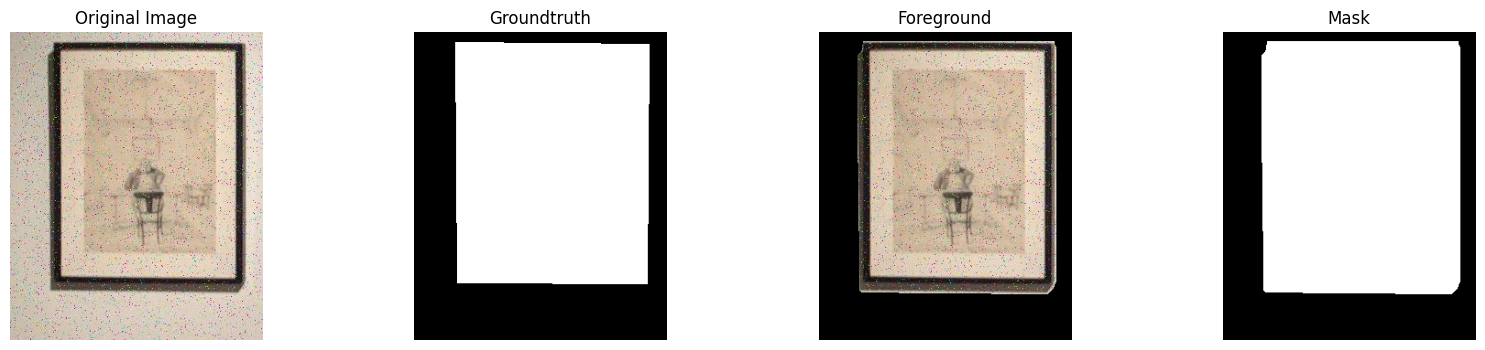

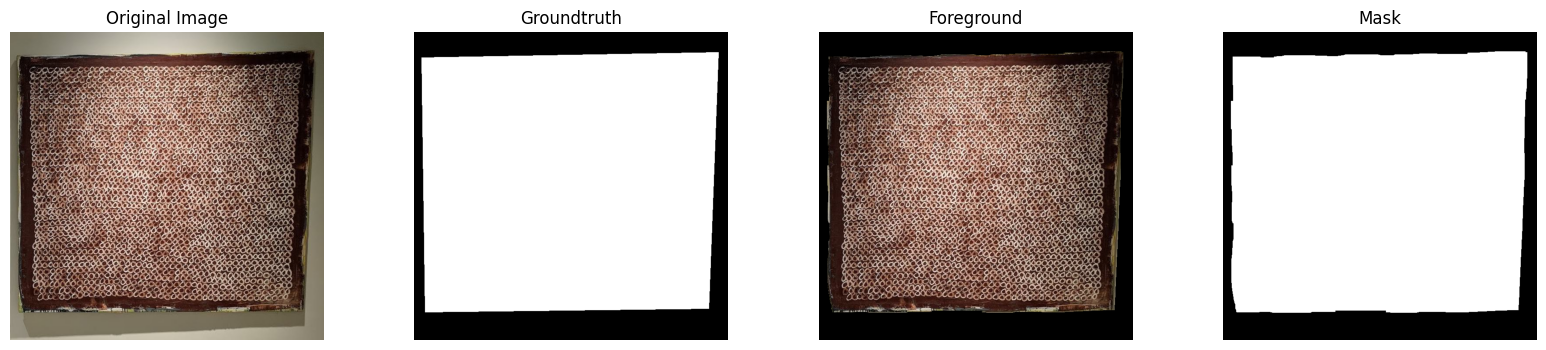

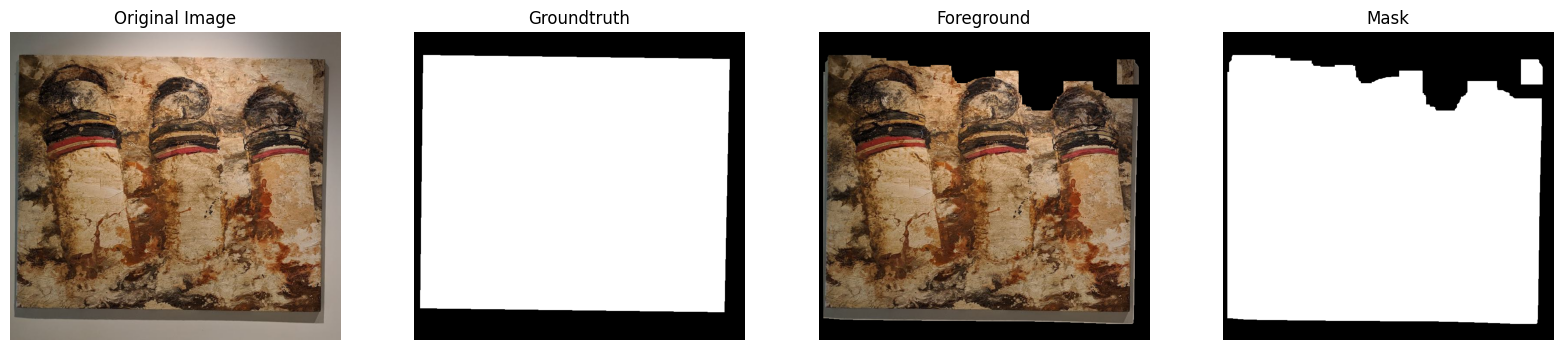

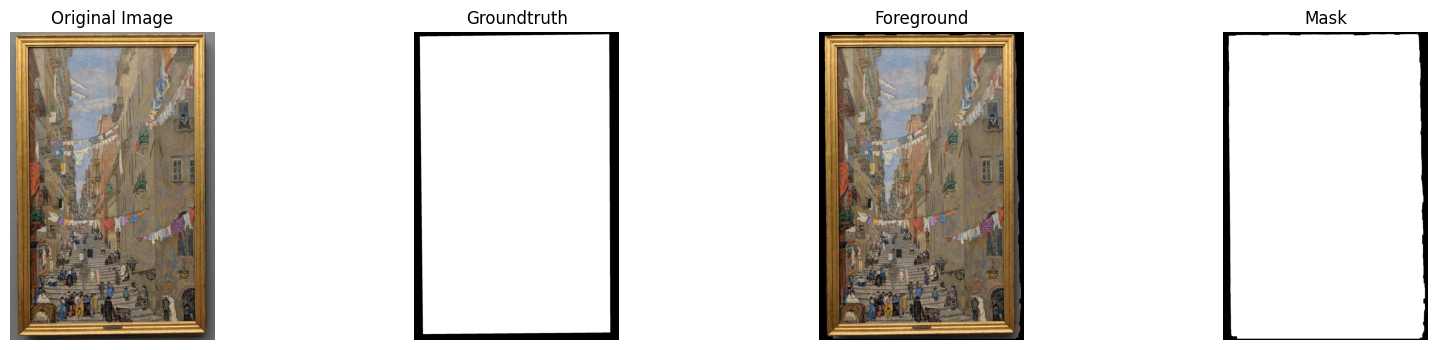

In [222]:
params = {
    'colorspace': ColorSpace.CieLab,
    'intervals': [7, 7, 7],
    'rows': 12,
    'columns': 12,
    'channels': [[0], [1], [2]]
}
BGDataset = ImageDataset(f'{DATA_DIRECTORY}/qsd2_w3', DescriptorType.Block, params)

background_files = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.png')]
background_files = sorted(background_files, key=lambda x: int(re.findall(r'\d+', x)[0]))


assert validate_order(
    [image.path.split('/')[-1].split('.')[0] for image in BGDataset.images],
    [bg_file.split('.')[0] for bg_file in background_files]
    )



# Loop will need to be changed to len(background_files) --> for i in range(0, len(background_files))
for i in range(15, 29):
    image = cv2.cvtColor(BGDataset.images[i].original_image, cv2.COLOR_BGR2RGB)

    # Original Image
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # Groundtruth
    ground_truth = os.path.join(f'{DATA_DIRECTORY}/qsd2_w3', background_files[i])
    ground_truth = cv2.imread(ground_truth)
    plt.subplot(1, 4, 2)
    plt.imshow(ground_truth)
    plt.title('Groundtruth')
    plt.axis('off')

    # Get foreground and mask
    foreground, mask = get_mask_and_foreground(image)
    plt.subplot(1, 4, 3)
    plt.imshow(foreground)
    plt.title('Foreground')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

In [28]:

bg_filenames = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.jpg')]
bg_filenames.sort()
gt_filenames = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd2_w3') if f.endswith('.png')]
gt_filenames.sort()

validate_order(bg_filenames, gt_filenames)

True

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.filters import median, gaussian, laplace, prewitt, sobel
from skimage.morphology import disk


def apply_filter(image, filter_type):
    if filter_type == 'median':
        return cv2.medianBlur(image, 5)
    elif filter_type == 'gaussian':
        return cv2.GaussianBlur(image, (3, 3), 0)
    elif filter_type == 'laplacian':
        return cv2.Laplacian(image, cv2.CV_64F)
    elif filter_type == 'prewitt':
        kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
        kernely = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
        return cv2.filter2D(image, -1, kernelx) + cv2.filter2D(image, -1, kernely)
    elif filter_type == 'sobel':
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        return cv2.magnitude(sobelx, sobely)
    elif filter_type == 'identity':
        return image
    else:
        raise ValueError(f"Unknown filter type: {filter_type}")

In [29]:
FOREGROUND_DIR = "data_results/foregrounds"
MASK_DIR = "data_results/masks"
dataset_name = "qsd2_w3"

if not os.path.exists(FOREGROUND_DIR):
    os.makedirs(FOREGROUND_DIR)

if not os.path.exists(MASK_DIR):
    os.makedirs(MASK_DIR)

In [219]:
import pandas as pd

for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground_w2(bg_image)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
results

,Metric,Value
0,Precision,0.912636
1,Recall,0.805510
2,F1 Score,0.831088


In [190]:
from scipy.fft import fft2, fftshift
import numpy as np

def get_magnitude_spectrum(image_array: np.ndarray) -> np.ndarray:
    # Step 2: Apply Fourier Transform
    fft_image = fft2(image_array)

    # Step 3: Shift the zero frequency component to the center
    fft_image_shifted = fftshift(fft_image)

    # Step 4: Compute the magnitude spectrum (log scale for visibility)
    magnitude_spectrum = np.log(np.abs(fft_image_shifted) + 1)

    return magnitude_spectrum


# Get magnitude spectrum
# noisy_image_spectrum = get_magnitude_spectrum(noisy_image)
# og_image_spectrum = get_magnitude_spectrum(og_image)


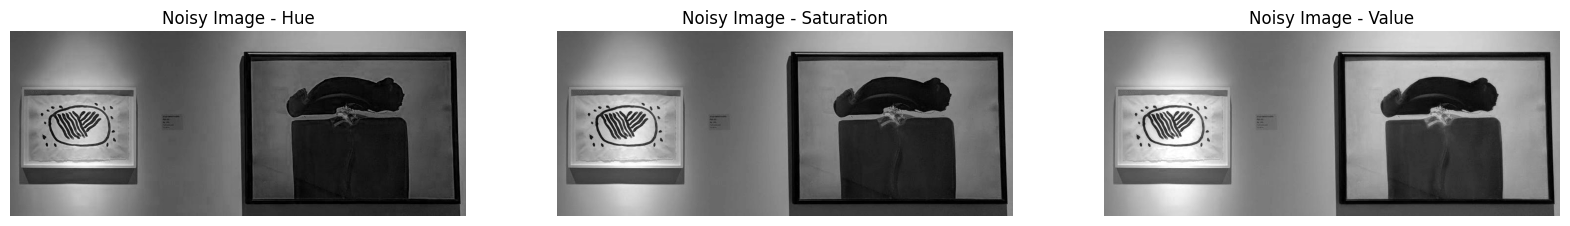

In [205]:
image_code = "00002"
noisy_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.jpg'))
og_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, 'non_augmented',f'{image_code}.jpg'))
gt_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, f'{image_code}.png'), cv2.IMREAD_GRAYSCALE)

# # Convert images to HSV
# noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2HSV)
# og_image = cv2.cvtColor(og_image, cv2.COLOR_BGR2HSV)

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
# Noisy Image HSV Channels
axs[0].imshow(noisy_image[:, :, 0], cmap='gray')
axs[0].set_title('Noisy Image - Hue')
axs[0].axis('off')

axs[1].imshow(noisy_image[:, :, 1], cmap='gray')
axs[1].set_title('Noisy Image - Saturation')
axs[1].axis('off')

axs[2].imshow(noisy_image[:, :, 2], cmap='gray')
axs[2].set_title('Noisy Image - Value')
axs[2].axis('off')
plt.show()
# Convert images to grayscale
# noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
# og_image = cv2.cvtColor(og_image, cv2.COLOR_BGR2GRAY)
# noisy_image = noisy_image[:,:, 2]
# og_image = og_image[:,:, 2]

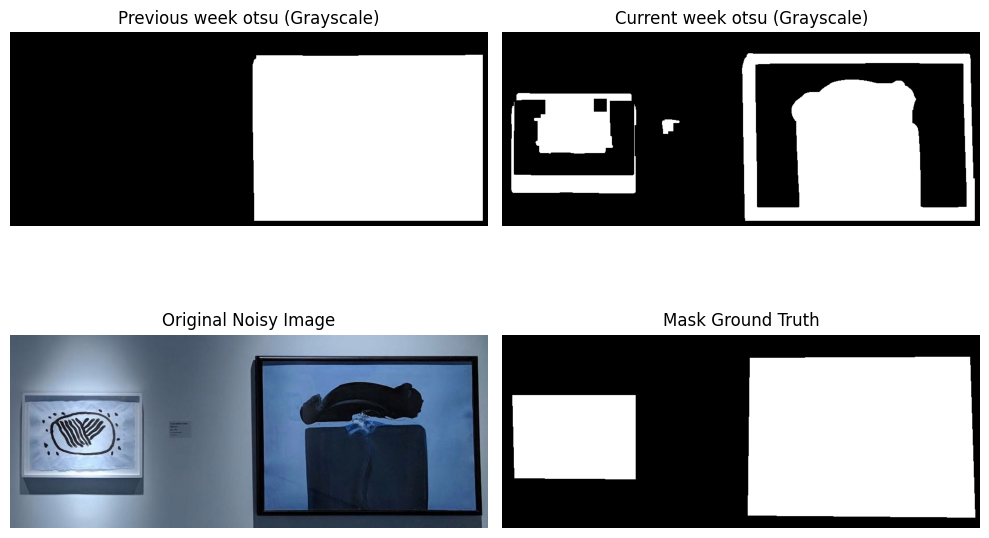

In [209]:
_, w2 = get_mask_and_foreground_w2(noisy_image)
_, w3 = get_mask_and_foreground(noisy_image)

# Plot the results
plt.figure(figsize=(10, 7))

# Original Noisy Image
plt.subplot(2, 2, 1)
plt.imshow(w2, cmap='gray')
plt.title('Previous week otsu (Grayscale)')
plt.axis('off')

# Magnitude Spectrum of Noisy Image

# Original Image
plt.subplot(2, 2, 2)
plt.imshow(w3, cmap='gray')
plt.title('Current week otsu (Grayscale)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(noisy_image, cmap='gray')
plt.title('Original Noisy Image')
plt.axis('off')

# Original Image
plt.subplot(2, 2, 4)
plt.imshow(gt_image, cmap='gray')
plt.title('Mask Ground Truth')
plt.axis('off')
plt.tight_layout()

plt.show()

In [167]:

plt.close()

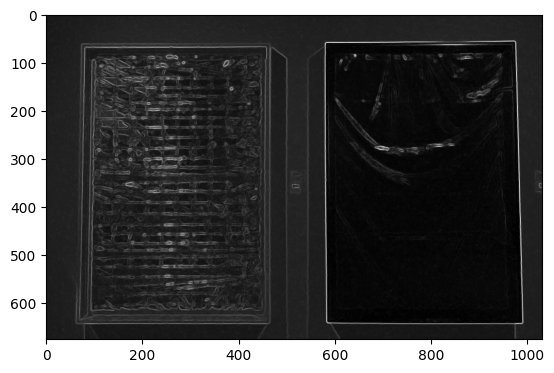

In [125]:
def normalize_image(image: np.ndarray) -> np.ndarray:
    """
    Normalize the input image to the range [0, 255].

    Parameters:
    image (np.ndarray): Input image to be normalized.

    Returns:
    np.ndarray: Normalized image.
    """
    image_min = image.min()
    image_max = image.max()

    # Shift and scale normalization
    normalized_image = (image - image_min) / (image_max - image_min) * 255

    return normalized_image


normalized_filtered_image = normalize_image(filtered_noisy_image)
plt.imshow(normalize_image(apply_filter(noisy_image, 'median')+normalized_filtered_image*5), cmap='gray')

In [223]:

for bg_filename, gt_filename in zip(bg_filenames, gt_filenames):
    bg_image = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, bg_filename))

    fg, mask = get_mask_and_foreground(bg_image)
    gt = cv2.imread(os.path.join(DATA_DIRECTORY, dataset_name, gt_filename), cv2.IMREAD_GRAYSCALE)

    # Define paths for saving
    foreground_path = os.path.join(FOREGROUND_DIR, bg_filename)
    mask_path = os.path.join(MASK_DIR, gt_filename)

    # Save the foreground and mask
    cv2.imwrite(foreground_path, cv2.cvtColor(foreground, cv2.COLOR_RGB2BGR))
    cv2.imwrite(mask_path, mask)

precision, recall, f1_score = evaluate_masks(MASK_DIR, os.path.join(DATA_DIRECTORY, dataset_name))
results = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1_score]
    })
results

,Metric,Value
0,Precision,0.941999
1,Recall,0.979247
2,F1 Score,0.958003
